In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

from matplotlib import rc

plt.rcParams.update({'font.size': 18})

rc('text', usetex=True)

# Utils 

In [2]:
def split_dataset(time, series, split_time):

    x_train = time[:split_time]
    y_train = series[:split_time]

    x_valid = time[split_time:]
    y_valid = series[split_time:]


    return x_train, y_train, x_valid, y_valid

def windowed_dataset(series, window_size, batch_size, shuffle_buffer, type_=None):

    if type_ == "RNN":

        #Expand dimensions for Recurrent Neural Networks use
        series = tf.expand_dims(series, axis=-1)

        #Convert to tf Dataset
        dataset = tf.data.Dataset.from_tensor_slices(series)

        #Divide dataset into windows of size window_size
        dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

        #Flatten dataser
        dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

        #Random shuffle and split into X and Y labels
        dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))

        #Create batches
        dataset = dataset.batch(batch_size).prefetch(1)

    else:

        #Convert to tf Dataset
        dataset = tf.data.Dataset.from_tensor_slices(series)

        #Divide dataset into windows of size window_size
        dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

        #Flatten dataser
        dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

        #Random shuffle and split into X and Y labels
        dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))

        #Create batches
        dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

def model_forecast(model, series, window_size):

    ds = tf.data.Dataset.from_tensor_slices(series)

    ds = ds.window(window_size, shift=1, drop_remainder=True)

    ds = ds.flat_map(lambda w: w.batch(window_size))

    ds = ds.batch(32).prefetch(1)

    forecast = model.predict(ds)

    return forecast

# Load data 

In [3]:
data = pd.read_csv("Data/GlobalLandTemperaturesByCity.csv")

data

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
...,...,...,...,...,...,...,...
8599207,2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24N,5.26E
8599208,2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24N,5.26E
8599209,2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24N,5.26E
8599210,2013-08-01,18.025,0.298,Zwolle,Netherlands,52.24N,5.26E


# Choose a given country to predict 

In [4]:
country_name = "Spain"
city_name = "Barcelona"

data_chosen = data[(data["City"] == city_name) & (data["Country"] == country_name)]

data_chosen

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
673805,1743-11-01,13.808,1.918,Barcelona,Spain,40.99N,2.13E
673806,1743-12-01,NaN,NaN,Barcelona,Spain,40.99N,2.13E
673807,1744-01-01,NaN,NaN,Barcelona,Spain,40.99N,2.13E
673808,1744-02-01,NaN,NaN,Barcelona,Spain,40.99N,2.13E
673809,1744-03-01,NaN,NaN,Barcelona,Spain,40.99N,2.13E
...,...,...,...,...,...,...,...
677039,2013-05-01,16.141,0.623,Barcelona,Spain,40.99N,2.13E
677040,2013-06-01,20.621,0.642,Barcelona,Spain,40.99N,2.13E
677041,2013-07-01,24.965,0.683,Barcelona,Spain,40.99N,2.13E
677042,2013-08-01,24.885,0.486,Barcelona,Spain,40.99N,2.13E


# Drop missing values

In [5]:
cleaned_data = data_chosen.dropna()

cleaned_data

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
673805,1743-11-01,13.808,1.918,Barcelona,Spain,40.99N,2.13E
673810,1744-04-01,15.406,1.931,Barcelona,Spain,40.99N,2.13E
673811,1744-05-01,15.890,1.840,Barcelona,Spain,40.99N,2.13E
673812,1744-06-01,20.068,1.820,Barcelona,Spain,40.99N,2.13E
673813,1744-07-01,22.547,1.812,Barcelona,Spain,40.99N,2.13E
...,...,...,...,...,...,...,...
677038,2013-04-01,14.342,0.482,Barcelona,Spain,40.99N,2.13E
677039,2013-05-01,16.141,0.623,Barcelona,Spain,40.99N,2.13E
677040,2013-06-01,20.621,0.642,Barcelona,Spain,40.99N,2.13E
677041,2013-07-01,24.965,0.683,Barcelona,Spain,40.99N,2.13E


# Create time series 

In [6]:
#Ommit the last point to compare final forecasting

series = cleaned_data["AverageTemperature"].values[:-1]

time = np.arange(0, len(series), 1)

# Plot time series

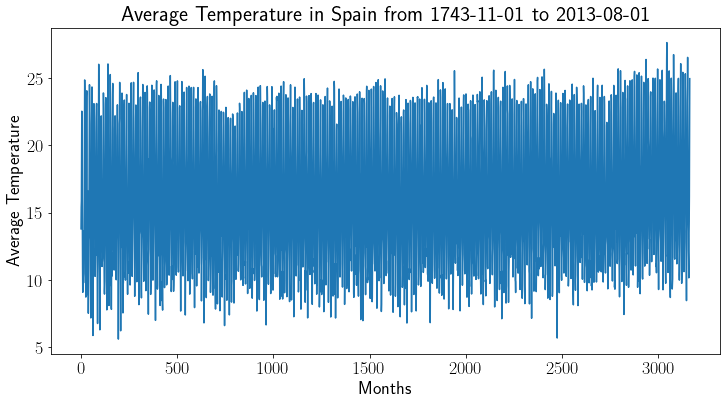

In [7]:
plt.figure(figsize=(12,6))

plt.plot(time, series)

plt.title("Average Temperature in Spain from %s to %s" % (cleaned_data["dt"].values[0], 
                                                          cleaned_data["dt"].values[-1]))

plt.xlabel("Months")
plt.ylabel("Average Temperature");

# Split data 

In [8]:
split_time = 2500

x_train, y_train, x_valid, y_valid = split_dataset(time, series, split_time)

# Compute windowed dataset 

In [9]:
window_size = 60
batch_size = 32
shuffle_buffer = 1000

dataset = windowed_dataset(y_train, window_size, batch_size, shuffle_buffer)

# DNN 

First we try a prediction with a simple deep  neural network 

## Construct and tune model 

In [10]:
min_lr = 1e-8
epchs = 100

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: min_lr * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=min_lr, momentum=0.9)

model.compile(loss="mse", optimizer=optimizer)

history = model.fit(dataset, epochs=epchs, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 113.0089
Epoch 2/100
77/77 [==============================] - 0s 2ms/step - loss: 105.1173
Epoch 3/100
77/77 [==============================] - 0s 2ms/step - loss: 96.6396
Epoch 4/100
77/77 [==============================] - 0s 2ms/step - loss: 87.9184
Epoch 5/100
77/77 [==============================] - 0s 2ms/step - loss: 79.0541
Epoch 6/100
77/77 [==============================] - 0s 2ms/step - loss: 70.1670
Epoch 7/100
77/77 [==============================] - 0s 2ms/step - loss: 61.4879
Epoch 8/100
77/77 [==============================] - 0s 2ms/step - loss: 53.4194
Epoch 9/100
77/77 [==============================] - 0s 2ms/step - loss: 46.3106
Epoch 10/100
77/77 [==============================] - 0s 2ms/step - loss: 40.5618
Epoch 11/100
77/77 [==============================] - 0s 2ms/step - loss: 36.2098
Epoch 12/100
77/77 [==============================] - 0s 2ms/step - loss: 32.8959
Epoch 13/100
77/77 [===

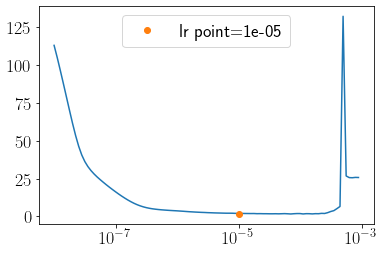

In [11]:
lrs = min_lr * (10 ** (np.arange(epchs) / 20))
losses = history.history["loss"]

lr_point = 1e-5

plt.semilogx(lrs, losses)
plt.plot([lr_point], [min(losses)], marker='o', ls='', label='lr point=%.e' % lr_point)

plt.legend();

## Compile optimised model

In [12]:
best_lr = 1e-5
best_epchs = 500

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=best_lr, momentum=0.9), metrics=["mae"])

history = model.fit(dataset,epochs=best_epchs,verbose=1)

Epoch 1/500
77/77 [==============================] - 0s 2ms/step - loss: 53.3725 - mae: 3.7238
Epoch 2/500
77/77 [==============================] - 0s 2ms/step - loss: 2.2721 - mae: 1.1921
Epoch 3/500
77/77 [==============================] - 0s 2ms/step - loss: 2.0760 - mae: 1.1434
Epoch 4/500
77/77 [==============================] - 0s 2ms/step - loss: 2.0840 - mae: 1.1370
Epoch 5/500
77/77 [==============================] - 0s 2ms/step - loss: 2.0745 - mae: 1.1301
Epoch 6/500
77/77 [==============================] - 0s 2ms/step - loss: 2.0519 - mae: 1.1349
Epoch 7/500
77/77 [==============================] - 0s 2ms/step - loss: 1.9062 - mae: 1.0890
Epoch 8/500
77/77 [==============================] - 0s 2ms/step - loss: 1.9069 - mae: 1.0871
Epoch 9/500
77/77 [==============================] - 0s 2ms/step - loss: 1.9699 - mae: 1.1018
Epoch 10/500
77/77 [==============================] - 0s 2ms/step - loss: 1.9064 - mae: 1.0887
Epoch 11/500
77/77 [==============================] - 0s 2

77/77 [==============================] - 0s 2ms/step - loss: 1.5050 - mae: 0.9707
Epoch 87/500
77/77 [==============================] - 0s 2ms/step - loss: 1.4943 - mae: 0.9656
Epoch 88/500
77/77 [==============================] - 0s 2ms/step - loss: 1.5061 - mae: 0.9736
Epoch 89/500
77/77 [==============================] - 0s 2ms/step - loss: 1.5278 - mae: 0.9815
Epoch 90/500
77/77 [==============================] - 0s 2ms/step - loss: 1.5353 - mae: 0.9800
Epoch 91/500
77/77 [==============================] - 0s 2ms/step - loss: 1.5486 - mae: 0.9889
Epoch 92/500
77/77 [==============================] - 0s 2ms/step - loss: 1.5506 - mae: 0.9784
Epoch 93/500
77/77 [==============================] - 0s 2ms/step - loss: 1.5469 - mae: 0.9837
Epoch 94/500
77/77 [==============================] - 0s 2ms/step - loss: 1.5248 - mae: 0.9756
Epoch 95/500
77/77 [==============================] - 0s 2ms/step - loss: 1.4908 - mae: 0.9635
Epoch 96/500
77/77 [==============================] - 0s 1ms/st

77/77 [==============================] - 0s 2ms/step - loss: 1.4680 - mae: 0.9612
Epoch 172/500
77/77 [==============================] - 0s 2ms/step - loss: 1.4347 - mae: 0.9451
Epoch 173/500
77/77 [==============================] - 0s 2ms/step - loss: 1.4638 - mae: 0.9612
Epoch 174/500
77/77 [==============================] - 0s 2ms/step - loss: 1.4694 - mae: 0.9626
Epoch 175/500
77/77 [==============================] - 0s 2ms/step - loss: 1.4379 - mae: 0.9525
Epoch 176/500
77/77 [==============================] - 0s 1ms/step - loss: 1.4134 - mae: 0.9426
Epoch 177/500
77/77 [==============================] - 0s 2ms/step - loss: 1.4575 - mae: 0.9538
Epoch 178/500
77/77 [==============================] - 0s 2ms/step - loss: 1.4237 - mae: 0.9487
Epoch 179/500
77/77 [==============================] - 0s 2ms/step - loss: 1.4431 - mae: 0.9507
Epoch 180/500
77/77 [==============================] - 0s 2ms/step - loss: 1.4749 - mae: 0.9634
Epoch 181/500
77/77 [==============================] -

77/77 [==============================] - 0s 2ms/step - loss: 1.3800 - mae: 0.9314
Epoch 257/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3983 - mae: 0.9376
Epoch 258/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3849 - mae: 0.9335
Epoch 259/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3908 - mae: 0.9345
Epoch 260/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3838 - mae: 0.9318
Epoch 261/500
77/77 [==============================] - 0s 2ms/step - loss: 1.4041 - mae: 0.9390
Epoch 262/500
77/77 [==============================] - 0s 2ms/step - loss: 1.4290 - mae: 0.9480
Epoch 263/500
77/77 [==============================] - 0s 2ms/step - loss: 1.4021 - mae: 0.9360
Epoch 264/500
77/77 [==============================] - 0s 2ms/step - loss: 1.4168 - mae: 0.9461
Epoch 265/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3761 - mae: 0.9296
Epoch 266/500
77/77 [==============================] -

77/77 [==============================] - 0s 2ms/step - loss: 1.3631 - mae: 0.9258
Epoch 342/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3646 - mae: 0.9269
Epoch 343/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3623 - mae: 0.9215
Epoch 344/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3647 - mae: 0.9277
Epoch 345/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3711 - mae: 0.9255
Epoch 346/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3744 - mae: 0.9337
Epoch 347/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3612 - mae: 0.9220
Epoch 348/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3723 - mae: 0.9268
Epoch 349/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3902 - mae: 0.9390
Epoch 350/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3522 - mae: 0.9230
Epoch 351/500
77/77 [==============================] -

77/77 [==============================] - 0s 2ms/step - loss: 1.3239 - mae: 0.9117
Epoch 427/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3300 - mae: 0.9112
Epoch 428/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3283 - mae: 0.9115
Epoch 429/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3305 - mae: 0.9137
Epoch 430/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3685 - mae: 0.9278
Epoch 431/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3435 - mae: 0.9184
Epoch 432/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3317 - mae: 0.9133
Epoch 433/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3468 - mae: 0.9162
Epoch 434/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3289 - mae: 0.9174
Epoch 435/500
77/77 [==============================] - 0s 2ms/step - loss: 1.3367 - mae: 0.9176
Epoch 436/500
77/77 [==============================] -

## Test

In [13]:
results = model_forecast(model, series, window_size)

## Results in validation dataset 

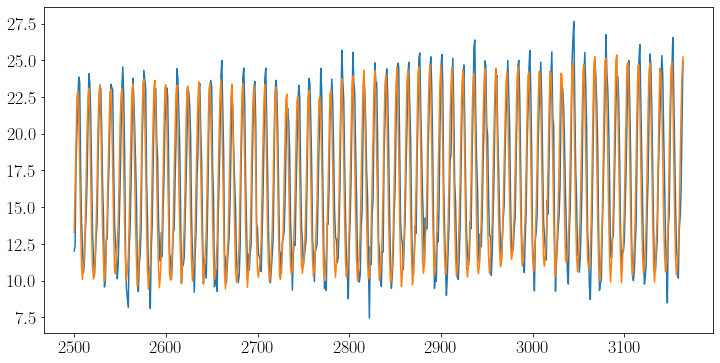

In [14]:
results_validation = results[split_time - window_size + 1 :][:, 0]

plt.figure(figsize=(12, 6))

plt.plot(x_valid, y_valid)
plt.plot(x_valid, results_validation)

In [15]:
tf.keras.metrics.mean_absolute_error(y_valid, results_validation).numpy()

2.3540895

## Results in whole dataset 

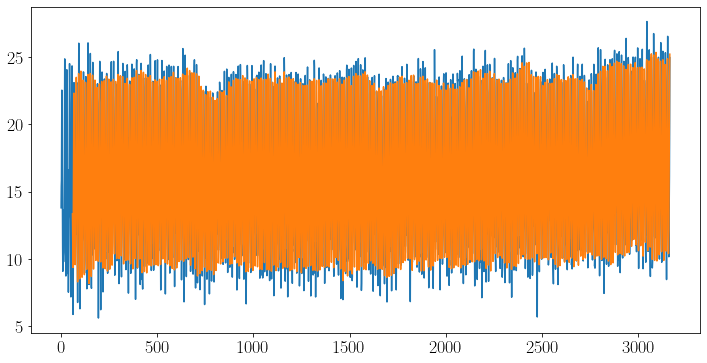

In [16]:
results_total = results[:, 0]

plt.figure(figsize=(12, 6))

plt.plot(time, series)
plt.plot(time[window_size - 1:], results_total)

In [17]:
tf.keras.metrics.mean_absolute_error(series[window_size - 1:], results_total).numpy()

2.3850577

## Plot loss 

In [18]:
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

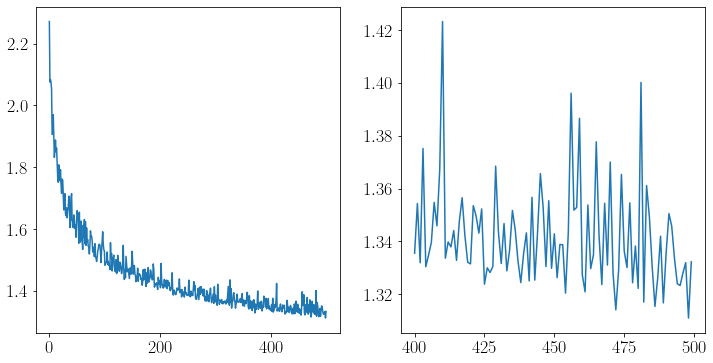

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)

plt.plot(epochs[1:], loss[1:])

plt.subplot(1, 2, 2)

plt.plot(epochs[-100:], loss[-100:])

So we could let the model learn still more! 

## Next month prediction 

In [20]:
result_next_month = model_forecast(model, series[len(series) - window_size :], window_size)

In [21]:
print("Real last point:", cleaned_data["AverageTemperature"].values[-1], " +/- ",
      cleaned_data["AverageTemperatureUncertainty"].values[-1],  "\tPredicted last point:", result_next_month[0][0])

Real last point: 24.885  +/-  0.486 	Predicted last point: 25.219116


Quite good prediction! 

# Can the trained model properly predict the temperature of a similar city like Madrid?

## Built new series 

In [22]:
country_name = "Spain"
city_name = "Madrid"

data_chosen = data[(data["City"] == city_name) & (data["Country"] == country_name)]

new_cleaned_data = data_chosen.dropna()

new_series = new_cleaned_data["AverageTemperature"].values[:-1]

new_time = np.arange(0, len(new_series), 1)

## Predict results for new city 

In [23]:
new_results = model_forecast(model, new_series, window_size)

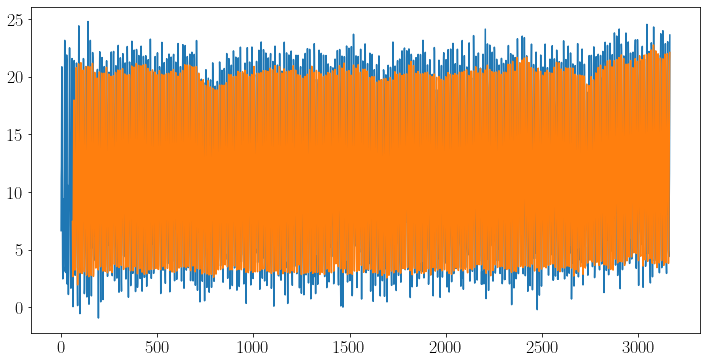

In [24]:
new_results_total = new_results[:, 0]

plt.figure(figsize=(12, 6))

plt.plot(new_time, new_series)
plt.plot(new_time[window_size - 1:], new_results_total)

In [25]:
tf.keras.metrics.mean_absolute_error(new_series[window_size -1 :], new_results_total).numpy()

3.0471344

In [26]:
result_next_month = model_forecast(model, new_series[len(series) - window_size :], window_size)

In [27]:
print("Real last point:", new_cleaned_data["AverageTemperature"].values[-1], " +/- ",
      new_cleaned_data["AverageTemperatureUncertainty"].values[-1],  "\tPredicted last point:", result_next_month[0][0])

Real last point: 22.599  +/-  0.436 	Predicted last point: 22.088003


Not bad at all! However, the MAE has increased a little

# What about a really different city

In [28]:
country_name = "Russia"
city_name = "Moscow"

data_chosen = data[(data["City"] == city_name) & (data["Country"] == country_name)]

new_cleaned_data = data_chosen.dropna()

new_series = new_cleaned_data["AverageTemperature"].values[:-1]

new_time = np.arange(0, len(new_series), 1)

In [29]:
new_results = model_forecast(model, new_series, window_size)

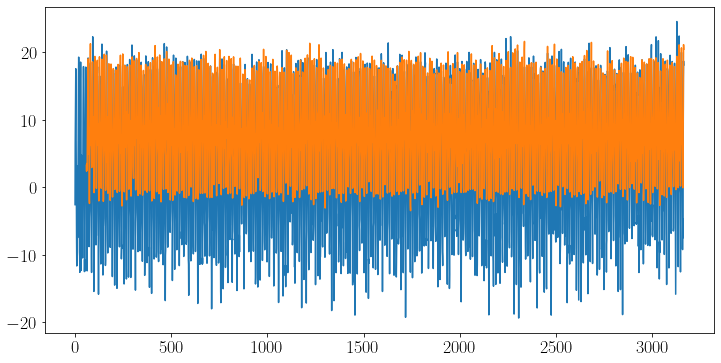

In [30]:
new_results_total = new_results[:, 0]

plt.figure(figsize=(12, 6))

plt.plot(new_time, new_series)
plt.plot(new_time[window_size - 1:], new_results_total)

In [31]:
tf.keras.metrics.mean_absolute_error(new_series[window_size -1 :], new_results_total).numpy()

5.6311607

In [32]:
result_next_month = model_forecast(model, new_series[len(new_series) - window_size :], window_size)

In [33]:
print("Real last point:", new_cleaned_data["AverageTemperature"].values[-1], " +/- ",
      new_cleaned_data["AverageTemperatureUncertainty"].values[-1],  "\tPredicted last point:", result_next_month[0][0])

Real last point: 17.485  +/-  0.3720000000000001 	Predicted last point: 20.476362


We can clearly see the model is not accurate enough.